<div style="border:solid green 2px; padding: 20px">
Константин, привет и хорошего дня! <br>
Меня зовут Сергей Дроздов, и я буду проверять твой проект. Предлагаю общаться на «ты». Если тебе удобнее общаться на "Вы", просто дай знать. 

Ты уже проделал большую работу над проектом, но давай сделаем его еще лучше. Ниже ты найдешь мои комментарии - пожалуйста, не перемещай, не изменяй и не удаляй их. Я буду использовать цветовую разметку:

<div class="alert alert-danger">
<b>Комментарий ревьюера: &#10060; </b> Так будут выделены комментарии с указаниями, обязательными к выполнению. Без их выполнения проект не будет принят. </div>

<div class="alert alert-warning">
<b>Комментарий ревьюера:
&#9888;</b> Так будут выделены некритичные замечания. Их отработка позволит улучшить качество твоего проекта.
</div>

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Так будут выделены остальные комментарии, полезные лайфхаки и ссылки на сторонние ресурсы </div>

Для наиболее эффективной и оперативной работы над проектом, мне хотелось бы иметь обратную связь. Не стесняйся задавать вопросы. Если ты что-либо меняешь в проекте, пожалуйста, комментируй это. Мне будет легче отследить изменения, если ты выделишь свои комментарии

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime

from IPython.display import display

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler 
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, cross_val_score, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# настройки
warnings.filterwarnings("ignore")

RANDOM_STATE=12345

In [2]:
def median_groupby(row):       
    '''функция для заполнения пропусков в столбце медианами по группе 
    получает строку, выдергивает значение столбца группировки (group_colomn) 
    возвращает значение соответствующей ему медианы
    
    До использования необходимо определить:
    nan_colomn - переменная задает столбец с пропуском
    group_colomn - переменная задает столбец с признаком по которому будем группировать для поиска медианы
    median_series - series со значениями медиан по группе
    '''
    try:
        row_group_value = row[group_colomn]
        group_median = median_series[row_group_value]
        return group_median
    except:
        return 'error group_median'

In [3]:
try:
    df = pd.read_csv("autos.csv")
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Ок, данные на базе! </div>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
display(df.sample(5).T)

,280344,120865,264665,56741,335015
DateCrawled,2016-03-14 11:54:48,2016-03-25 01:57:05,2016-03-14 14:53:10,2016-04-03 00:59:56,2016-03-13 19:51:31
Price,4790,799,13900,1350,2550
VehicleType,NaN,wagon,wagon,sedan,wagon
RegistrationYear,2017,1999,2012,1999,2000
Gearbox,manual,NaN,manual,manual,manual
Power,105,0,136,90,0
Model,golf,a4,c_klasse,a_klasse,3er
Kilometer,150000,150000,150000,150000,150000
RegistrationMonth,7,4,3,8,0
FuelType,gasoline,petrol,gasoline,gasoline,petrol


### Обработка дубликатов

In [6]:
print('Количество дубликатов:', df.duplicated().sum())

Количество дубликатов: 4


С учетом полей с датами вероятность случайного совпадения строк очень мала. Удаляем.

In [7]:
df = df.drop_duplicates()

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Хорошо!</div>

### Пропуски в модели автомобиля

Пропуски в столбце 'Model' заполним значением 'unknown'.

In [8]:
df['Model'] = df['Model'].fillna('unknown')

Модель без марки автомобиля не всегда дает однозначную информацию о том что это за авто (встречаются совпадения наименований модели).

В модельном ряде большинства брендов есть как "недорогие" так и "премиальные" (дорогие) модели.

Таким образом значения 'Brand' и 'Model' будет корректно учитывать в связке.

In [9]:
#"соберем" марку и модель автомобиля в 1 признак
df['Brand_Model'] = df['Brand'] + '_' + df['Model']

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Хорошо! </div>

### Нулевая цена

In [10]:
df['Price'].describe()

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

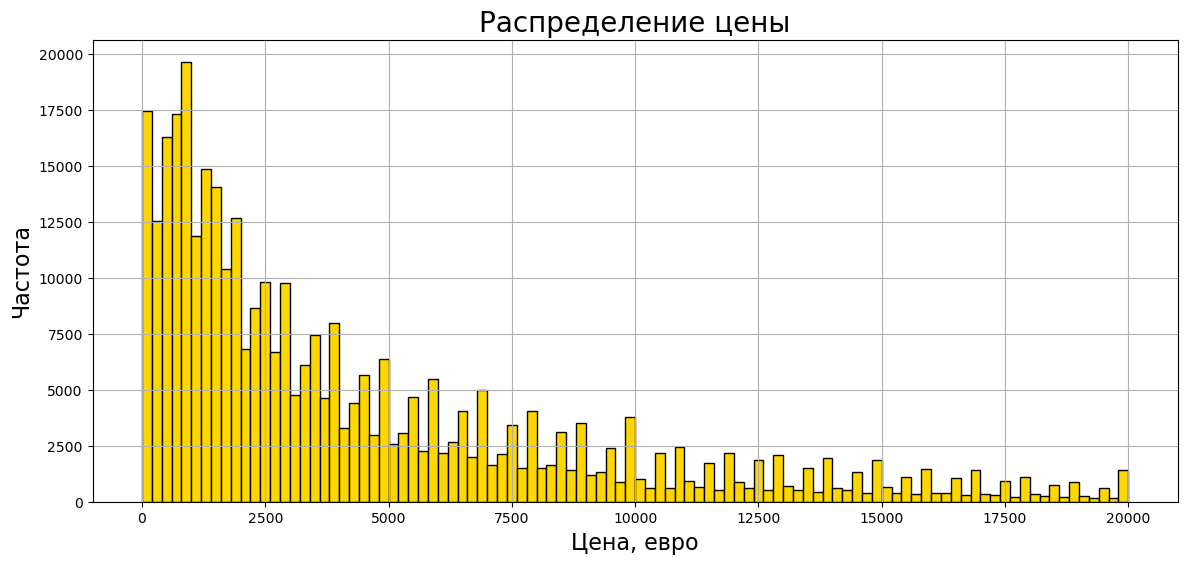

In [11]:
df['Price'].plot.hist(bins=100, edgecolor = 'black', figsize=(14, 6), grid=True, color='gold')
plt.title('Распределение цены', fontsize=20)
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Цена, евро', fontsize=16);

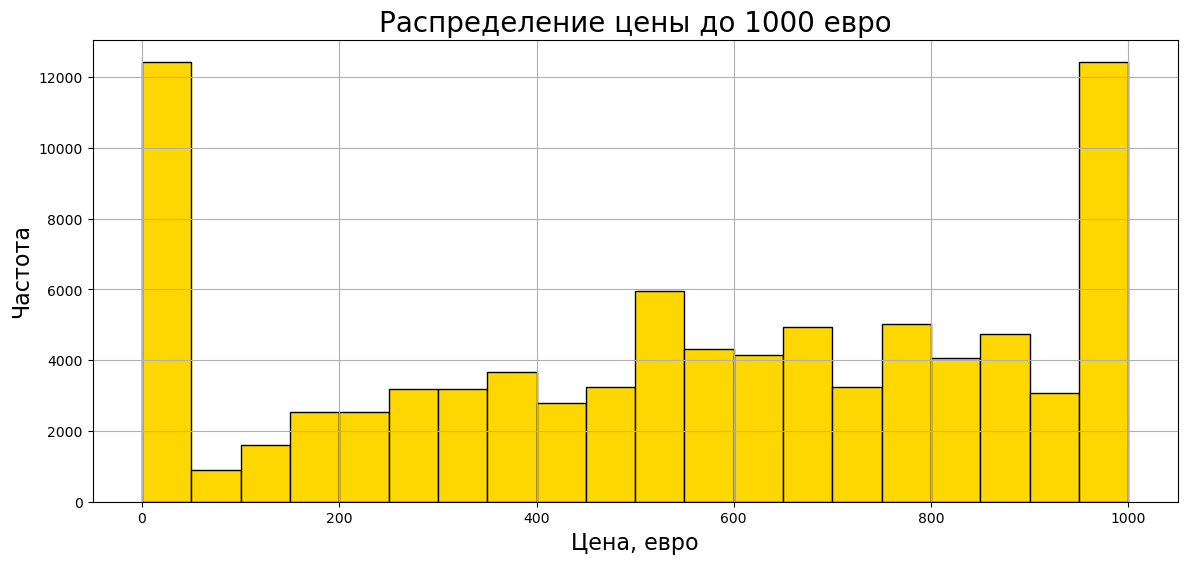

In [12]:
df['Price'][df['Price']<=1000].plot.hist(bins=20, edgecolor = 'black', figsize=(14, 6), grid=True, color='gold')
plt.title('Распределение цены до 1000 евро', fontsize=20) 
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Цена, евро', fontsize=16);

In [13]:
print('количество автомобилей с 0 ценой:')
print(len(df[df['Price']==0]))
print('доля автомобилей с 0 ценой:')
print(len(df[df['Price']==0])/len(df))

количество автомобилей с 0 ценой:
10772
доля автомобилей с 0 ценой:
0.030398035923412302


Судя по почтовым индексам и маркам автомобилей сервис работает с объявлениями центральной европы (в основном Германия). Продажа автомобилей там вероятно имеет свои особенности. Возможно нулевая цена при продаже указана для старых/неисправных автомобилей, которые выгоднее отдать даром чем утилизировать. Необходимы комментарии заказчика. 

А возможно такая цена - просто ошибка при заполнении формы объявления. На данный момент правильнее удалить строки с нулевой ценой. 

In [14]:
df = df[df['Price']>0]

In [15]:
print('количество автомобилей с ценой < 50 евро:')
print(len(df[df['Price']<50]))
print('доля автомобилей с ценой < 50 евро:')
print(len(df[df['Price']<50])/len(df))

количество автомобилей с ценой < 50 евро:
1651
доля автомобилей с ценой < 50 евро:
0.00480510371282302


In [16]:
df = df[df['Price']>=50]
df['Price'].describe()

count    341942.000000
mean       4577.108556
std        4514.861088
min          50.000000
25%        1200.000000
50%        2900.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

Отсеяли объявления с нулевой ценой. 10772 строки - около 3%.  
Также объявления с ценой менее 50 евро (около 4,5 тыс. руб.) вероятно являются недостоверными даже для старого или аварийного автомобиля. Удалили 1651 строку - около 0,5%

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Отлично! </div>

### Недостоверная дата регистрации

In [17]:
print(df['RegistrationYear'].value_counts())
print(df['RegistrationMonth'].value_counts())

2000    22818
1999    21896
2005    21404
2006    19650
2001    19591
        ...  
2200        1
8888        1
2290        1
9450        1
1946        1
Name: RegistrationYear, Length: 139, dtype: int64
3     33749
0     32067
6     30753
4     28627
5     28445
7     26605
10    25568
11    23719
12    23702
9     23326
1     22551
8     22077
2     20753
Name: RegistrationMonth, dtype: int64


Присутствуют недостоверные значения RegistrationYear, а также RegistrationMonth == 0.

In [18]:
print('количество автомобилей с недостоверным/нерелевантным годом выпуска:')
print(len(df[(df['RegistrationYear']<1970) | (df['RegistrationYear']>2016)]))
print('доля автомобилей с недостоверным/нерелевантным годом выпуска:')
print(len(df[(df['RegistrationYear']<1970) | (df['RegistrationYear']>2016)])/len(df))

количество автомобилей с недостоверным/нерелевантным годом выпуска:
14834
доля автомобилей с недостоверным/нерелевантным годом выпуска:
0.04338162612372858


In [19]:
#удалим строки с неправильным годом регистрации
df = df[(df['RegistrationYear']>=1970) | (df['RegistrationYear']<=2016)]

In [20]:
#"соберем" дату регистрации (RegistrationYear и RegistrationMonth) в 1 признак
df['HowOld_Month'] = 2016*12 - df['RegistrationYear']*12 - df['RegistrationMonth'] #Возраст автомобиля в месяцах

<div class="alert alert-danger">
<b>Комментарий ревьюера: &#10060; </b> Обрати, пожалуйста, внимание на дату выгрузки из бд(2016 г.) </div>

<div class="alert alert-info"> <b>Комментарий студента:</b>
    Исправил! :)
</div>

Удалили 14834 строк (0,4%). Признаки RegistrationYear и RegistrationMonth собраны в один: RegistrationYearMonth.

### Удаление неинформативных признаков

In [21]:
#удалим неинформативные признаки
df = df.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode', 'NumberOfPictures', # не несут пользы
                  'RegistrationMonth', 'RegistrationYear', # собраны в 1 признак
                  'Model', 'Brand'], axis=1) # собраны в 1 признак

### Недостоверная мощность

In [22]:
df['Power'].describe()

count    341942.000000
mean        111.206713
std         188.254677
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

In [23]:
print('0.995 квантиль', df['Power'].quantile(.995))

0.995 квантиль 334.0


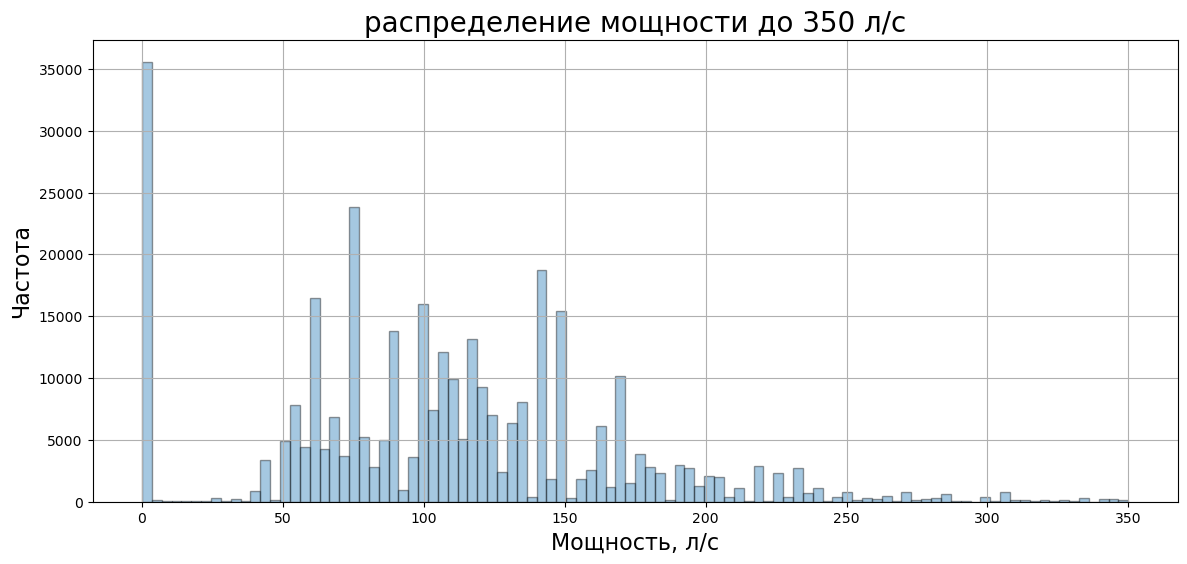

In [24]:
df['Power'][df['Power']<=350].plot.hist(
    bins=100, edgecolor = 'black', figsize=(14, 6), grid=True, alpha = 0.4)
plt.title('распределение мощности до 350 л/с', fontsize=20)
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Мощность, л/с', fontsize=16);

In [25]:
#посмотрим на автомобили с мощностью от 1 до 40 л/с
display(df[(df['Power']<40) & (df['Power']>0)].sample(6).T)

,110383,308270,68669,188239,275908,306463
Price,350,4000,1450,4980,1800,16800
VehicleType,small,small,small,convertible,NaN,other
Gearbox,manual,manual,manual,manual,manual,manual
Power,39,23,18,27,34,24
Kilometer,80000,100000,125000,50000,50000,150000
FuelType,petrol,petrol,petrol,petrol,petrol,petrol
Repaired,NaN,no,NaN,no,NaN,no
Brand_Model,fiat_seicento,fiat_500,fiat_500,volkswagen_other,volkswagen_kaefer,ford_other
HowOld_Month,202,594,504,606,372,1031


Среди объявлений есть маломощные атомобили типа trabant

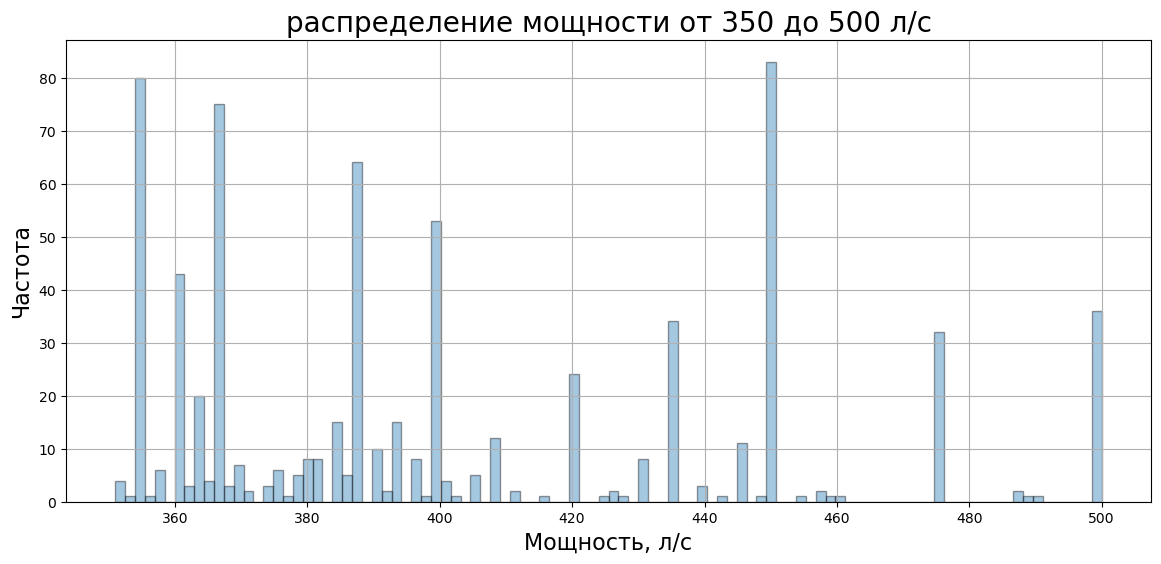

In [26]:
df['Power'][(df['Power']>350) & (df['Power']<=500)].plot.hist(
    bins=100, edgecolor = 'black', figsize=(14, 6), grid=True, alpha = 0.4)
plt.title('распределение мощности от 350 до 500 л/с', fontsize=20)
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Мощность, л/с', fontsize=16);

In [27]:
#посмотрим на автомобили с мощностью от 350 л/с до 500 л/с
print(len(df[(df['Power']>350) & (df['Power']<=500)]))
display(df[(df['Power']>350) & (df['Power']<=500)].sample(7).T)

724


,116916,122952,218513,345012,139614,210948,266880
Price,13750,16990,17500,1200,20000,16500,15000
VehicleType,coupe,coupe,sedan,suv,sedan,coupe,NaN
Gearbox,manual,manual,auto,auto,auto,auto,auto
Power,390,354,387,450,408,367,360
Kilometer,150000,150000,150000,90000,100000,150000,150000
FuelType,petrol,petrol,petrol,petrol,petrol,petrol,NaN
Repaired,yes,no,no,yes,no,no,no
Brand_Model,bmw_3er,audi_other,mercedes_benz_s_klasse,porsche_cayenne,bmw_7er,bmw_6er,volkswagen_golf
HowOld_Month,69,98,106,150,86,121,-10


В списке в основном porsche, bmw, mercedes_benz и т.п., хотя встречаются и неправдоподобные volkswagen golf 365 л/с

In [28]:
#посмотрим на автомобили с мощностью свыше 500 л/с
print('количество автомобилей с мощностью свыше 500 л.с.:')
print(len(df[df['Power']>500]))
print('доля автомобилей с мощностью свыше 500 л.с.:')
print(len(df[df['Power']>500])/len(df))
display(df[df['Power']>500].sample(7).T)

количество автомобилей с мощностью свыше 500 л.с.:
422
доля автомобилей с мощностью свыше 500 л.с.:
0.0012341274251188798


,220411,171089,207383,131401,216993,255268,344689
Price,1499,1750,2100,4500,11950,7500,14900
VehicleType,NaN,sedan,small,sedan,convertible,convertible,suv
Gearbox,manual,manual,manual,auto,manual,manual,auto
Power,6012,6010,1399,3454,16312,1432,521
Kilometer,125000,90000,150000,150000,20000,150000,150000
FuelType,NaN,petrol,gasoline,petrol,petrol,petrol,petrol
Repaired,no,no,no,NaN,no,no,no
Brand_Model,volkswagen_polo,opel_agila,ford_fiesta,mercedes_benz_e_klasse,audi_a4,bmw_3er,porsche_cayenne
HowOld_Month,-12,112,158,174,92,165,114


Тут уже совсем неверотные мощности. Т.к. в выборке предсталены автомобили стоимостью до 20000 евро можем считать что мощность свыше 500 л./с указана ошибочно.

In [29]:
#в Power оставляем значения в диапазоне 1-500 л.с. Остальным присваиваем NaN
df['Power'] = df['Power'].where(df['Power']!=0, np.NaN)
df['Power'] = df['Power'].where(df['Power']<=500, np.NaN)

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Отлично! </div>

### Заполнение пропусков

In [30]:
nan_colomn = 'Power'             #переменная задает столбец с пропуском
group_colomn = 'Brand_Model'     #переменная задает столбец по которому будем группировать для поиска медианы
median_series = df.groupby(group_colomn)[nan_colomn].median() #series со значениями медиан по группе

#Заполняем 'Power' медианой соответствующей марки/модели
df[nan_colomn] = df[nan_colomn].fillna(df.apply(median_groupby, axis=1))

In [31]:
display(df[df['Power'].isna()==True].T)

,234296
Price,3800
VehicleType,wagon
Gearbox,manual
Power,NaN
Kilometer,30000
FuelType,gasoline
Repaired,NaN
Brand_Model,land_rover_serie_1
HowOld_Month,456


In [32]:
#удаляем одну строку для которой не нашлось медианы
df = df.dropna(subset = ['Power'])

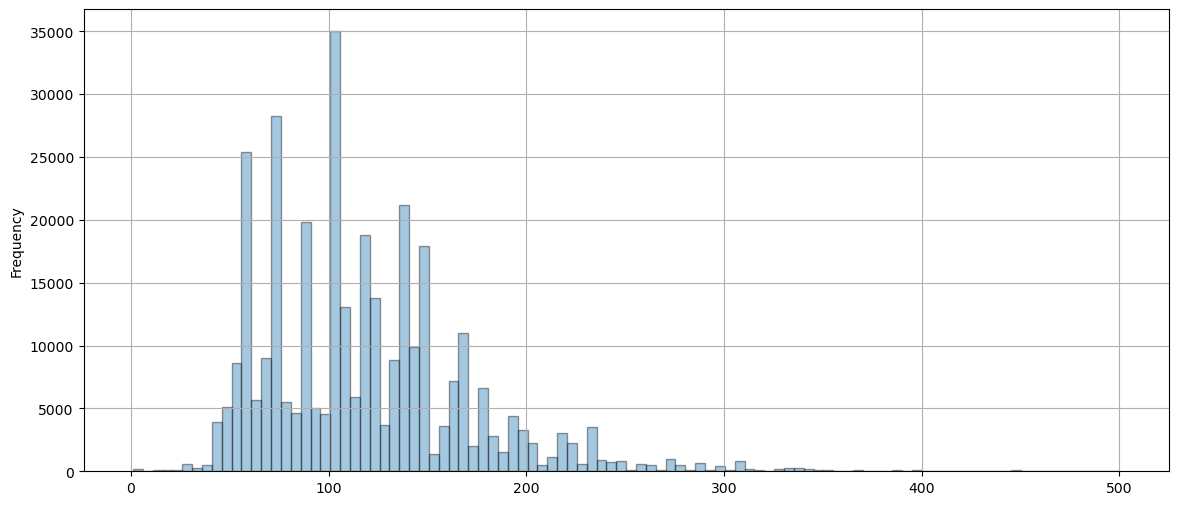

In [33]:
df['Power'].plot.hist(bins=100, edgecolor = 'black', figsize=(14, 6), grid=True, alpha = 0.4);

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Отлично! </div>

In [34]:
#оставшиеся пропуски в категориальных столбцах (VehicleType, Gearbox, FuelType, NotRepaired) заполним строкой 'unknown' 
df = df.fillna('unknown')

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Отлично! </div>

In [35]:
df['Power'] = df['Power'].astype('int')

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 341941 entries, 0 to 354368
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Price         341941 non-null  int64 
 1   VehicleType   341941 non-null  object
 2   Gearbox       341941 non-null  object
 3   Power         341941 non-null  int32 
 4   Kilometer     341941 non-null  int64 
 5   FuelType      341941 non-null  object
 6   Repaired      341941 non-null  object
 7   Brand_Model   341941 non-null  object
 8   HowOld_Month  341941 non-null  int64 
dtypes: int32(1), int64(3), object(5)
memory usage: 24.8+ MB


### Корреляция

<AxesSubplot:>

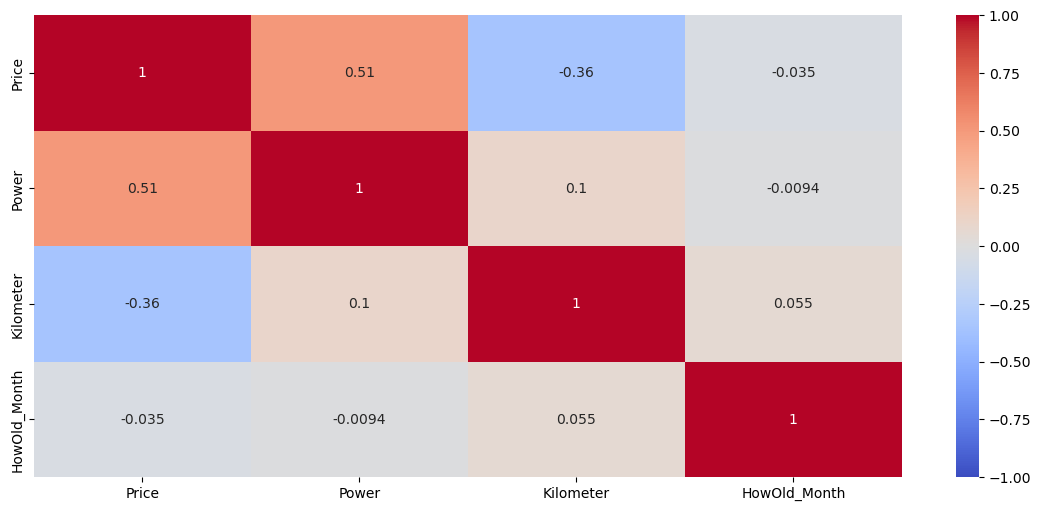

In [37]:
fig, ax = plt.subplots(figsize=(14,6))
sns.heatmap(df.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', fmt='.2g')

<div class="alert alert-warning">
<b>Комментарий ревьюера:
&#9888;</b> Молодец, что не забываешь про корреляцию, но стоит добавить выводы
</div>

Выявлены следующие корреляции: мощность автомобиль имеет сильную положительную взаимосвязь с его ценой. Отрицательную среднюю взаимосвязь имеет цена с километражем. В остальном значимых корреляций не выявлено.

### Вывод по шагу 1

Из 354369 строк осталось 341941.

In [38]:
round((354369 - (10772 + 1651 + 14834 + 422))/354369, 2)

0.92

На очистке потеряли 8%. В основном за счет некорректной цены и даты выпуска автомобиля.

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Отлично! </div>

## Обучение моделей

In [39]:
kfold = KFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)

### 1. LightGBM

Для работы алгоритма с категориальными признаками необходимо передать соответствующим столбцам тип 'category'

In [40]:
df_2 = df.copy(deep=True)

In [41]:
#смена типа категорийных столбцов с object на category
cat_col = df_2.select_dtypes(include='object').columns
for col in cat_col:
    df_2[col] = df_2[col].astype('category')

In [42]:
features_train_2, features_test_2, target_train_2, target_test_2 = train_test_split(
    df_2.drop(['Price'], axis=1), df_2['Price'], test_size=0.2, random_state=RANDOM_STATE)

In [43]:
beg_time = datetime.datetime.now()
model_lgbm = LGBMRegressor()

parametrs = {
    "n_estimators": range(300, 401, 50), 
    "max_depth": range(10, 17, 3),
    'learning_rate': [0.1, 0.2]
}

grid = RandomizedSearchCV(model_lgbm, parametrs, cv=kfold, scoring='neg_mean_absolute_error')
grid.fit(features_train_2, target_train_2)
params = grid.best_params_
model_lgbm = LGBMRegressor().set_params(**params)
negmse = cross_val_score(model_lgbm, features_train_2, target_train_2, cv=kfold, scoring='neg_mean_squared_error')

model_lgbm.name = 'model_lgbm (LGBMRegressor),         '
model_lgbm.rmse = np.sqrt(-negmse.mean())
model_lgbm.time = (datetime.datetime.now()-beg_time).seconds
model_lgbm.params = params

print('Модель:', model_lgbm.name, '  rmse(евро): %.0f' %model_lgbm.rmse, '  время работы(сек.):',model_lgbm.time)
print('Параметры:', model_lgbm.params)

Модель: model_lgbm (LGBMRegressor),            rmse(евро): 1602   время работы(сек.): 66
Параметры: {'n_estimators': 400, 'max_depth': 13, 'learning_rate': 0.2}


<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Отлично! </div>

### 2. RandomForestRegressor

Для деревянных моделей необходимо закодировать категориальные столбцы

In [44]:
df_3 = df.copy(deep=True)

<div class="alert alert-warning">
<b>Комментарий ревьюера:
&#9888;</b> Для OHE лучше использовать OneHotEncoder и только после разделения на выборки, get_dummies не вставить в пайплайны + могут быть ошибки в кодировании, при кодировании после деления придётся проверять, что получились одинаковые признаки и в одинаковом порядке. OneHotEncoder может работать с значениями признака, которого не было в тестовой выборке, может с column_transformer, пайплайнами и вообще просто создан для этого. Пример использования <a href = "https://colab.research.google.com/drive/1_gAMXcQKoCShB_l8FNtYEejMnosm9mvt?usp=sharing">OHE</a>. Так же без разделения выборки до кодирования возникает утечка в данных
</div>

<div class="alert alert-info"> <b>Комментарий студента:</b>
    Пересчитал ниже способом который нашел, надеюсь всё правильно :)
</div>

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    df_3.drop(['Price'], axis=1), df_3['Price'], test_size=0.2, random_state=RANDOM_STATE)

In [46]:
df_3_beg_time = datetime.datetime.now() #учтем время на подготовку признаков

df_3.time = (datetime.datetime.now()-df_3_beg_time).seconds

In [47]:
num_columns = ['HowOld_Month', 'Power']
cat_columns = ['VehicleType', 'Gearbox', 'Brand_Model', 'FuelType', 'Repaired', 'Kilometer']

transformer = ColumnTransformer(
    [("enc", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), cat_columns)],
    remainder='passthrough'
)

transformer_linear = ColumnTransformer(
            [("ohe", OneHotEncoder(handle_unknown = 'ignore', sparse=False, drop='first'), cat_columns),
            ("scaler", StandardScaler(), num_columns)],
            remainder='passthrough'
)

def fit_model(estimator, param_grid, X_train, y_train):
    model = GridSearchCV(estimator=estimator, 
                            param_grid=param_grid, 
                            n_jobs=-1, 
                            cv=4,
                            scoring='neg_root_mean_squared_error')

    model.fit(X_train, y_train)

    best_index = model.best_index_
    best_rmse = round(model.cv_results_['mean_test_score'][best_index], 1)

    return model

In [48]:
beg_time = datetime.datetime.now()

rf_estimator = Pipeline([
    ('transformer', transformer),
    ('rf', RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

rf_param_grid =  {
    'rf__n_estimators': list(range(50, 76, 25)),
    "rf__max_depth": list(range(15, 21, 5)),
}

rf_best_model = fit_model(
    estimator=rf_estimator,
    param_grid=rf_param_grid,
    X_train=X_train,
    y_train=y_train
)

gs_rf_best_score = rf_best_model.best_score_ * -1
gs_rf_best_params = rf_best_model.best_params_

rf_best_model.name = 'model_rf (RandomForestRegressor),         '
rf_best_model.rmse = np.sqrt(-negmse.mean())
rf_best_model.time = (datetime.datetime.now()-beg_time).seconds
rf_best_model.params = gs_rf_best_params

print('Модель:', rf_best_model.name, '  rmse(евро): %.0f' %rf_best_model.rmse, '  время работы(сек.):',rf_best_model.time)
print('Параметры:', rf_best_model.params)

Модель: model_rf (RandomForestRegressor),            rmse(евро): 1602   время работы(сек.): 37
Параметры: {'rf__max_depth': 20, 'rf__n_estimators': 75}


### CatBoostRegressor

In [49]:
beg_time = datetime.datetime.now()

catboost_estimator = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False, cat_features=cat_columns)

catboost_param_grid = {
    "iterations": range(100, 201, 100),
    "learning_rate": [0.15, 0.25],
    "depth": range(9, 13, 3)
}

catboost_best_model = fit_model(
    estimator=catboost_estimator,
    param_grid=catboost_param_grid,
    X_train=X_train,
    y_train=y_train
)

gs_cb_best_score = catboost_best_model.best_score_ * -1
gs_cb_best_params = catboost_best_model.best_params_

catboost_best_model.name = 'model_cb (CatBoostRegressor),         '
catboost_best_model.rmse = np.sqrt(-negmse.mean())
catboost_best_model.time = (datetime.datetime.now()-beg_time).seconds
catboost_best_model.params = gs_cb_best_params

print('Модель:', catboost_best_model.name, '  rmse(евро): %.0f' %catboost_best_model.rmse, '  время работы(сек.):',catboost_best_model.time)
print('Параметры:', catboost_best_model.params)

Модель: model_cb (CatBoostRegressor),            rmse(евро): 1602   время работы(сек.): 611
Параметры: {'depth': 12, 'iterations': 200, 'learning_rate': 0.25}


### Линейная регрессия

In [50]:
df_4 = df.copy(deep=True)

In [51]:
#Создадим новые признаки и заполним их медианами соответствующих категорий
#cat_col = df_4.select_dtypes(include='object').columns
df_4_beg_time = datetime.datetime.now() #учтем время на подготовку признаков

for col in cat_col:
    nan_colomn = col + '_MeanPrice'
    group_colomn = col
    median_series = df_2.groupby(group_colomn)['Price'].median()
    
    df_4[nan_colomn] = np.NaN
    df_4[nan_colomn] = df_4[nan_colomn].fillna(df_4.apply(median_groupby, axis=1))
    
    df_4 = df_4.drop([col], axis=1)
    df_4[nan_colomn] = df_4[nan_colomn].astype('int')
    
df_4.time = (datetime.datetime.now()-df_4_beg_time).seconds

In [52]:
df_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 341941 entries, 0 to 354368
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype
---  ------                 --------------   -----
 0   Price                  341941 non-null  int64
 1   Power                  341941 non-null  int32
 2   Kilometer              341941 non-null  int64
 3   HowOld_Month           341941 non-null  int64
 4   VehicleType_MeanPrice  341941 non-null  int32
 5   Gearbox_MeanPrice      341941 non-null  int32
 6   FuelType_MeanPrice     341941 non-null  int32
 7   Repaired_MeanPrice     341941 non-null  int32
 8   Brand_Model_MeanPrice  341941 non-null  int32
dtypes: int32(6), int64(3)
memory usage: 18.3 MB


<AxesSubplot:>

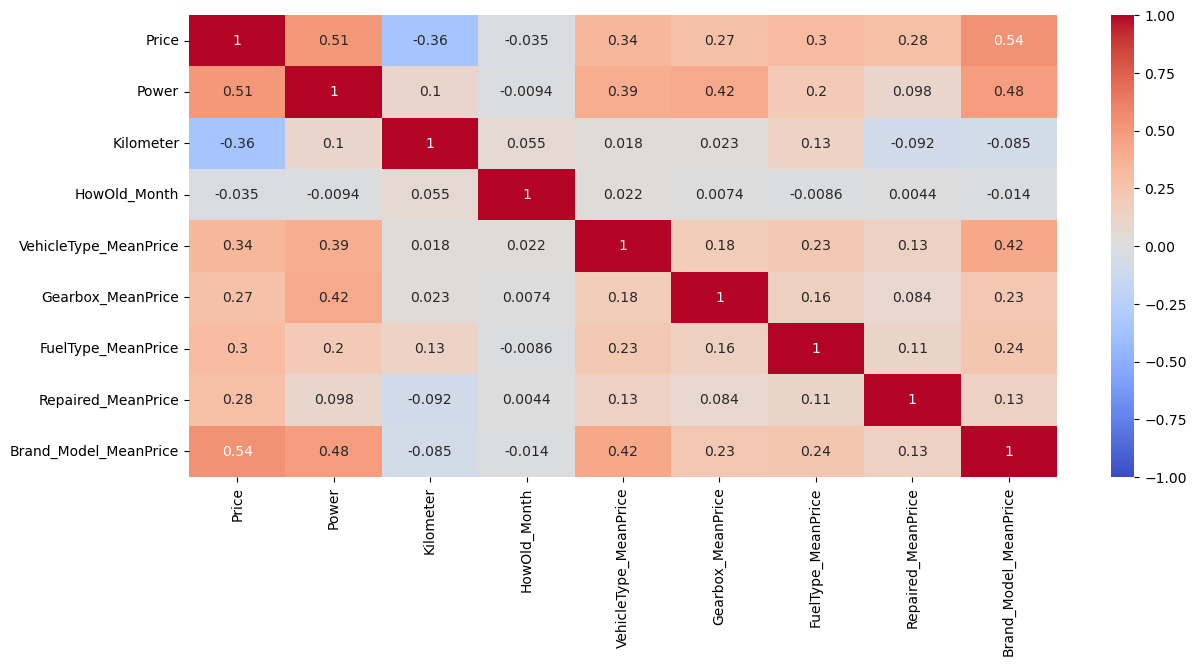

In [53]:
fig, ax = plt.subplots(figsize=(14,6))
sns.heatmap(df_4.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', fmt='.2g')

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Молодец, что не забываешь про проверку на мультиколлинеарность! </div>

In [54]:
features_train_4, features_test_4, target_train_4, target_test_4 = train_test_split(
    df_4.drop(['Price'], axis=1), df_4['Price'], test_size=0.2, random_state=RANDOM_STATE)

In [55]:
#Нормализуем
scaler = StandardScaler()
scaler.fit(features_train_4)
features_train_4 = scaler.transform(features_train_4)
features_test_4 = scaler.transform(features_test_4)

In [56]:
beg_time = datetime.datetime.now()
model_lr = LinearRegression()

negmse = cross_val_score(model_lr, features_train_4, target_train_4, cv=kfold, scoring='neg_mean_squared_error')

model_lr.name = 'model_lr (LinearRegression),      '
model_lr.rmse = np.sqrt(-negmse.mean())
model_lr.time = (datetime.datetime.now()-beg_time).seconds + df_4.time

print('Модель:', model_lr.name, '  rmse(евро): %.0f' %model_lr.rmse, '  время работы(сек.):',model_lr.time)

Модель: model_lr (LinearRegression),         rmse(евро): 2973   время работы(сек.): 19


### Выводы по шагу 2

Были подготовлены 4 модели: LGBMRegressor, RandomForestRegressor, CatBoost и LinearRegression. Сравним модели далее:

<div class="alert alert-danger">
<b>Комментарий ревьюера: &#10060; </b> Я насчитал 4, чтобы избежать путаницы лучше моделям(да и признакам) давать осмысленные названия (например model_lgbm). Так же стоит подробнее расписать выводы (какие модели с какими гиперпараметрами) </div>

<div class="alert alert-info"> <b>Комментарий студента:</b>
    Исправил:)
</div>

## Анализ моделей

In [58]:
model_list = [model_lgbm, rf_best_model, catboost_best_model, model_lr]
for model in model_list:
    print('Модель:', model.name, '  train rmse(евро): %.0f' %model.rmse, '  время на подготовку (сек.):',model.time)

Модель: model_lgbm (LGBMRegressor),            train rmse(евро): 1602   время на подготовку (сек.): 66
Модель: model_rf (RandomForestRegressor),            train rmse(евро): 1602   время на подготовку (сек.): 37
Модель: model_cb (CatBoostRegressor),            train rmse(евро): 1602   время на подготовку (сек.): 611
Модель: model_lr (LinearRegression),         train rmse(евро): 2973   время на подготовку (сек.): 19


<div class="alert alert-danger">
<b>Комментарий ревьюера: &#10060; </b> Не забывай, пожалуйста, про выводы </div>

Наиболее быстрая модель - Линейная регрессия, но у нёё самая большая среднеквадратичная ошибка (2973). Остальные модели показывают одинаковый результат (1602), но самая быстрая из них это RandomForestRegressor (37 секунд).

<div class="alert alert-info"> <b>Комментарий студента:</b>
    Сделано :)
</div>

### Тестирование лучшей модели

<div class="alert alert-danger">
<b>Комментарий ревьюера: &#10060; </b> Обрати, пожалуйста, внимание на следущее: тестируем мы только итоговую модель, выбранную на предыдущем шаге </div>

In [63]:
X_test_rf = X_test.copy()
X_test_rf[cat_columns] = X_test_rf[cat_columns].astype("category")

rmse = mean_squared_error(y_test, rf_best_model.predict(X_test_rf)) ** 0.5
print(f"RMSE Random Forest Regressor на тестовой выборке: {rmse:.1f}")

RMSE Random Forest Regressor на тестовой выборке: 1615.7


<div class="alert alert-info"> <b>Комментарий студента:</b>
    Сделано :)
</div>

### Вывод по шагу 3

Меньше всего ошибаются RandomForestRegressor, CatBoostRegressor и LGBMRegressor. Однако именно RandomForestRegressor показывает самый быстрый результат.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей

<b>Итоговый комментарий ревьюера:</b> Молодец, хорошая работа, есть пара критических моментов, которые необходимо исправить, а именно:
1. Промежуточные выводы
2. Год регистрации
3. Тестирование модели<br>
Так же советую обратить внимание на использование OHE, выше добавил ссылку на пример использования. Для ускорения подбора гиперпараметров можно использовать RandomizesSearchCV.Ниже оставляю пару ссылок для самообучения! Успехов!

<div class="alert alert-success">
<b>Рубрика “Полезные ссылки”:
✅</b> <br>
<a href = "https://sphweb.bumc.bu.edu/otlt/MPH-Modules/PH717-QuantCore/PH717-Module9-Correlation-Regression/PH717-Module9-Correlation-Regression4.html">Коэффициенты корреляции</a><br>
<a href = "https://www.researchgate.net/profile/Paul-Louangrath/post/Ranking_or_scoring_variables_using_conditional_probability/attachment/59d63c45c49f478072ea7c1a/AS%3A273748962283533%401442278246675/download/100+Statistical+Tests.pdf">100 Statistical tests</a><br>
<a href = "https://loginom.ru/blog/missing">Обработка пропусков</a><br>
<a href = "https://coderlessons.com/tutorials/python-technologies/izuchai-siborna/siborn-kratkoe-rukovodstvo"> Seaborn</a><br>
<a href = "https://habr.com/ru/post/502958/"> Plotly</a><br>
<a href = "https://medium.com/@jetbootsmaker/%D0%BF%D0%BE%D0%B2%D1%8B%D1%88%D0%B0%D0%B5%D0%BC-%D0%BF%D1%80%D0%BE%D0%B4%D1%83%D0%BA%D1%82%D0%B8%D0%B2%D0%BD%D0%BE%D1%81%D1%82%D1%8C-%D0%BF%D1%80%D0%B8-%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B5-%D1%81-jupyter-notebook-81a1cab8bac1"> Повышаем продуктивность при работе с Jupyter</a><br>
<a href = "https://towardsdatascience.com/5-things-you-should-know-about-covariance-26b12a0516f1">5 Things You Should Know About Covariance</a><br>
    <a href = "https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/">Выбросы</a><br>
    <a href = "https://www.kaggle.com/code/baghern/a-deep-dive-into-sklearn-pipelines/notebook">Pipeline</a>
</div>